# detect someone with separation mood or emotional distress 

In [89]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import threading
import warnings
warnings.filterwarnings('ignore', category=Warning)

In [109]:
data_list = []
for i in range(30):
    df = pd.read_csv(f'../data/data_EEG/s{i:02d}.csv', header=None)
    data_list.append(df.transpose().to_numpy())

In [111]:
dataset = np.array(data_list)
dataset = dataset.reshape(30, 760, 775, 1).astype('float32')
dataset

array([[[[ 4.4760e+00],
         [ 1.2080e+00],
         [-2.5460e+00],
         ...,
         [-6.2028e+00],
         [-6.0741e+00],
         [-6.1582e+00]],

        [[-6.4077e+00],
         [-6.6993e+00],
         [-6.8622e+00],
         ...,
         [ 7.2465e-01],
         [ 2.0171e+00],
         [ 2.8709e+00]],

        [[ 3.2545e+00],
         [ 3.1757e+00],
         [ 2.6660e+00],
         ...,
         [-1.3017e+01],
         [-1.5792e+01],
         [-1.8757e+01]],

        ...,

        [[-1.0143e+00],
         [ 7.5662e-01],
         [ 2.4005e+00],
         ...,
         [-2.6952e+00],
         [ 5.6360e-01],
         [ 3.9012e+00]],

        [[ 7.0700e+00],
         [ 9.8254e+00],
         [ 1.1978e+01],
         ...,
         [-1.0031e+00],
         [-1.0031e+00],
         [-1.0031e+00]],

        [[-1.0031e+00],
         [-1.0031e+00],
         [-1.0031e+00],
         ...,
         [-9.8351e-04],
         [-9.8351e-04],
         [-9.8351e-04]]],


       [[[ 1.3990e+01],


# Leave-One-Out Cross-Validation (LOOCV) Explained

	Notice how rows 30-35 are excluded from the initial processing (like transpose and to_numpy) - these are reserved as the test set, not for validation!

	This method called Leave-One-Out Cross-Validation (LOOCV), is particularly valuable for EEG and other neuroimaging data because:

	Personalization Matters: Each participant has unique baseline brain activity, signal amplitudes, and response patterns

	Maximized Data Utility: With typical EEG studies having just 20-40 participants, LOOCV gives the most statistically reliable results

In [113]:
y = np.array([0,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1])
y = y.reshape(-1, 1)
y

array([[0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [114]:
seed = 42
tf.random.set_seed(seed)

# Model Building


# Early Stop:

	We introduced early stop here: early stop is a technique used to prevent overfitting. Patience=5 means with 5 consecutive 0 or negative improvement, we will stop trainning and return the best model.

# LSTM:

	The change I made is LSTM (Long-Short Term Memory), which is a special type of RNN that 'forgets' but not only 'remembers'. LSTM is useful for EEG data, since after one math task, the brain state data should approximated be set back to the baseline. This means forgetting is suitable for experiments with multiple discrete tasks.

# Convolutional Layers for Feature Extraction:

	I kept this part from the orgininal notebook. It uses Conv2D with 16 filters and strides of 2 to process the EEG's spatial dimensions, followed by max pooling and batch normalization to stabilize activations.

A 20% dropout layer helps prevent overfitting to electrode-specific noise. These layers extract localized spatial patterns from the raw input before reshaping for LSTM processing, preserving the critical spatial relationships between electrodes while reducing dimensionality.

The combination of strided convolutions and pooling ensures the network focuses on the most salient neural activity patterns. =) (why am I explaining this its father should have done the work!)

In [115]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the model
model = tf.keras.models.Sequential([
    # Convolutional layers for feature extraction
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), activation='relu',
                           input_shape=(760, 775, 1), padding='same'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    # Reshape to fit LSTM input format
    tf.keras.layers.Reshape((190, -1)),  # Adjusted based on Conv2D+MaxPool2D output

    # LSTM for sequence modeling
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),

    # Fully connected output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])

# Show model summary
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 380, 388, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 190, 194, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 190, 194, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 190, 194, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 190, 3104)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 190, 64)        │       811,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,937 (3.14 MB)

 Trainable params: 823,905 (3.14 MB)

 Non-trainable params: 32 (128.00 B)

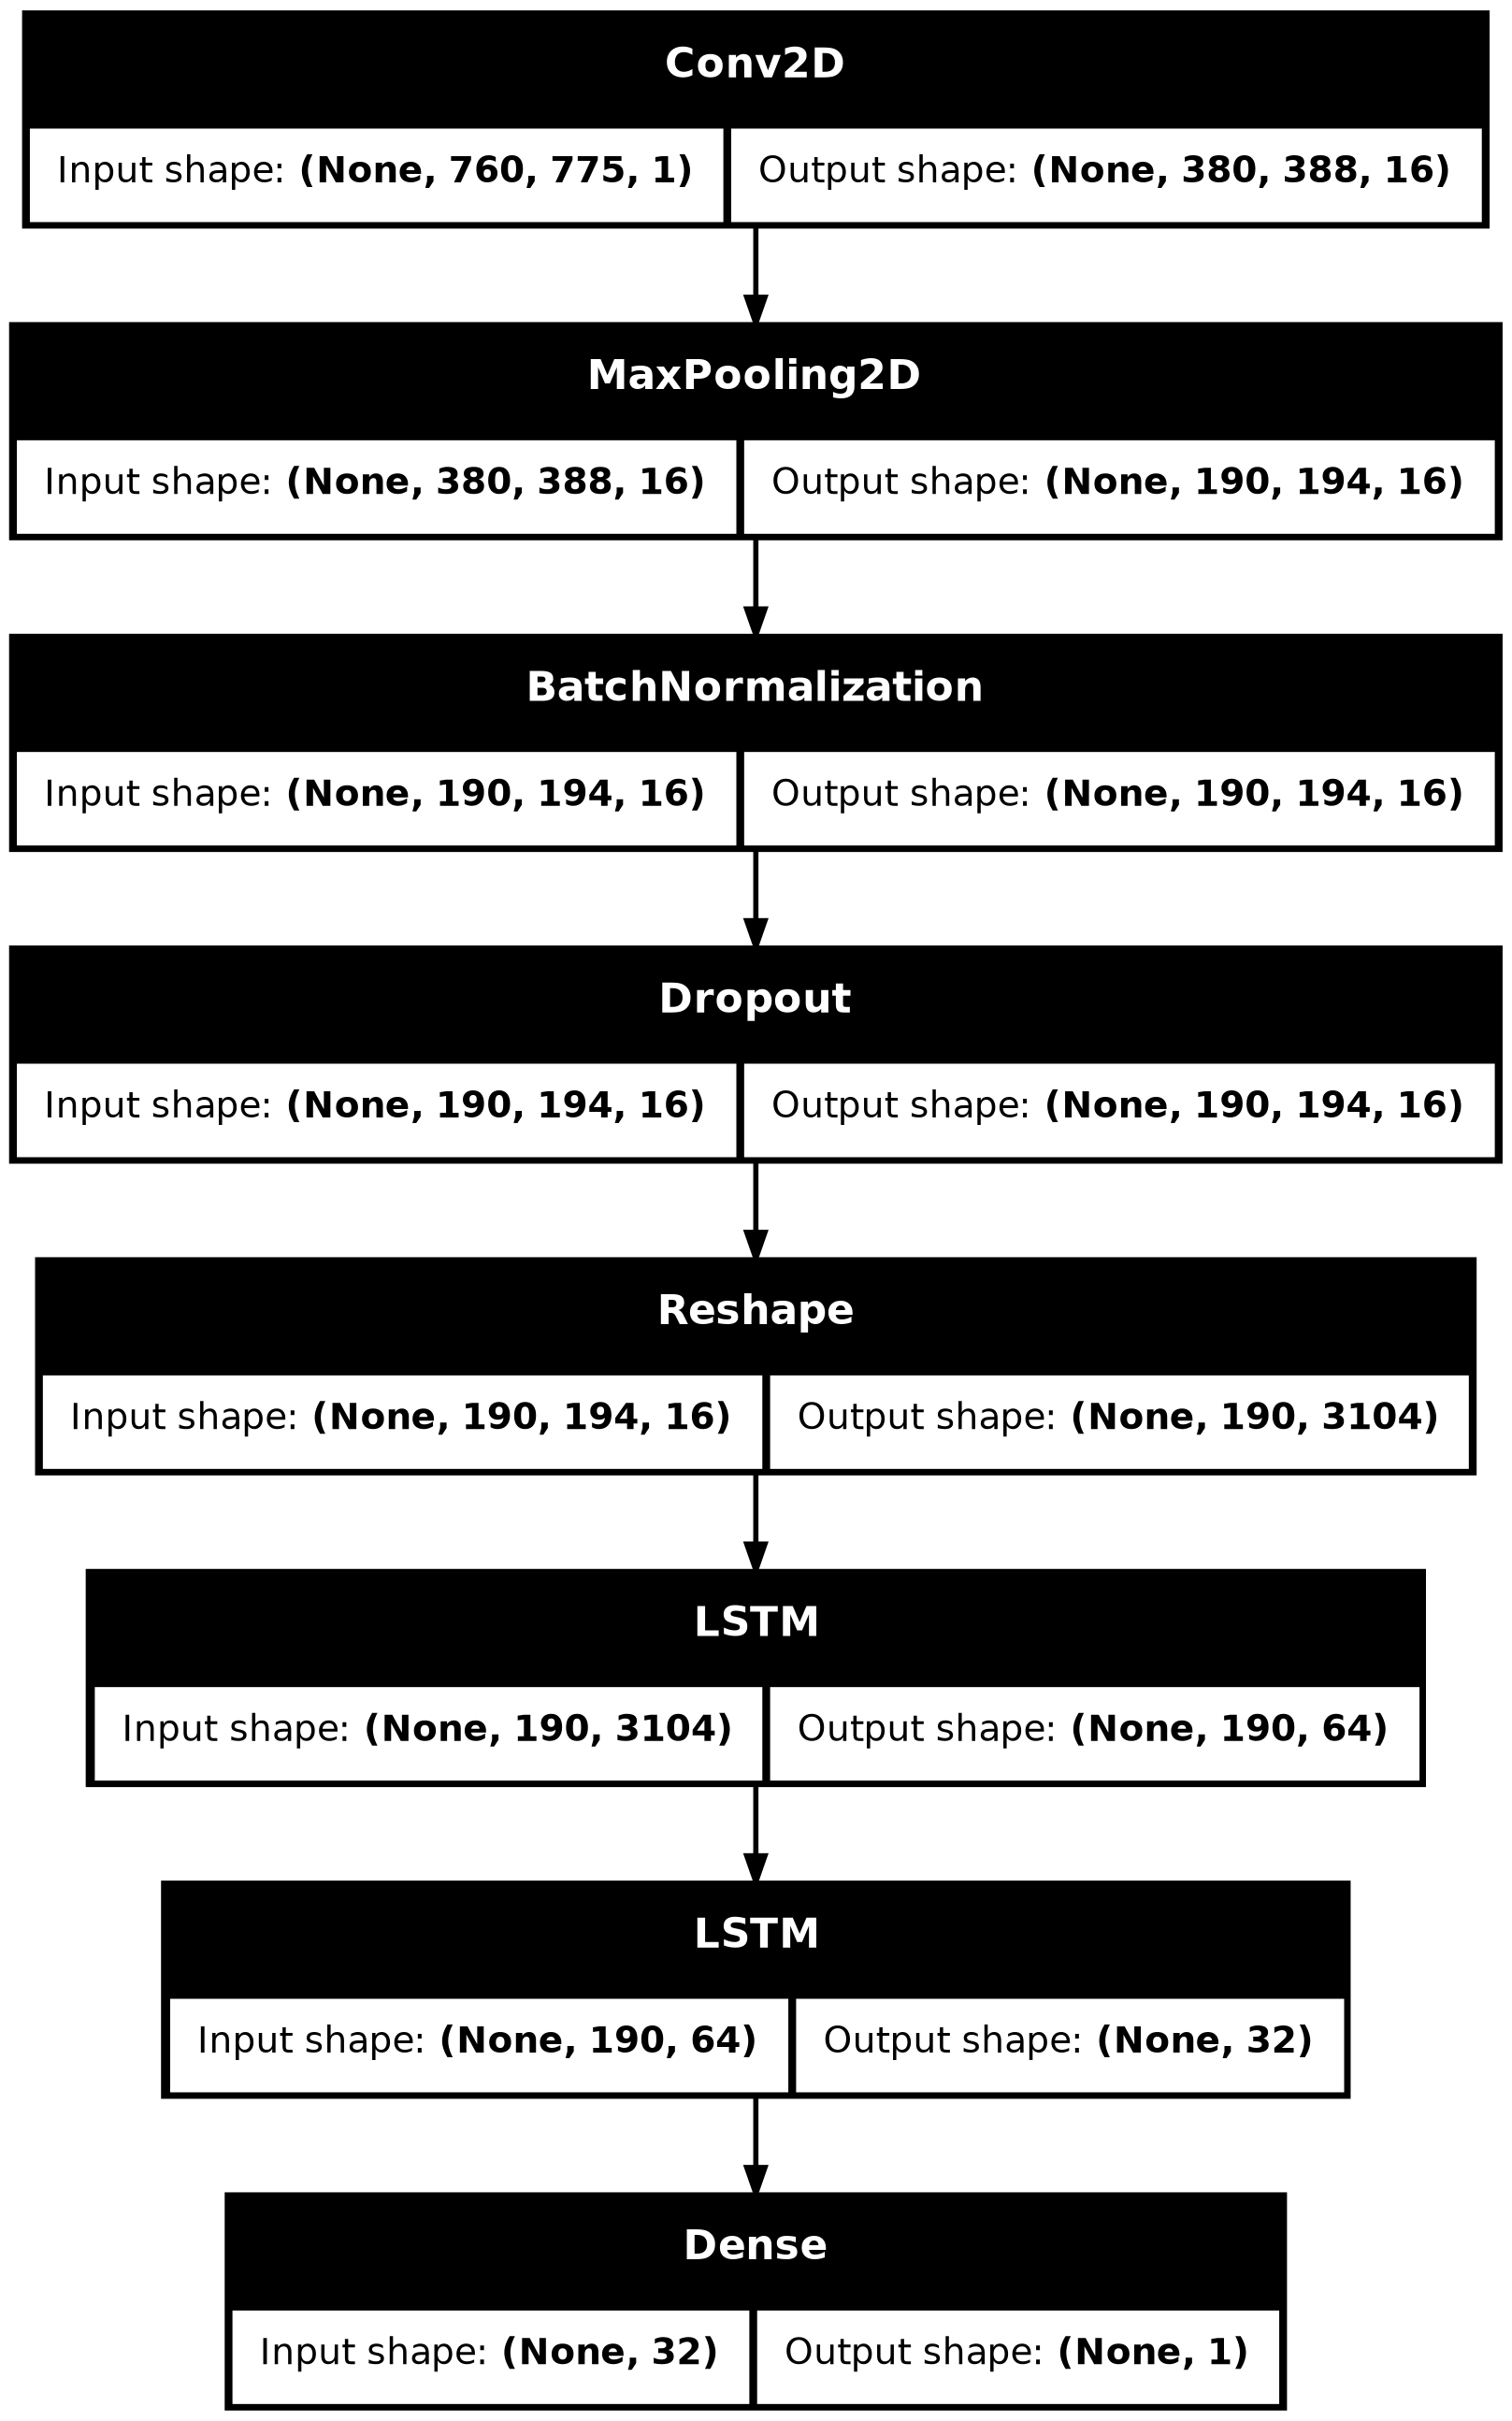

In [117]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')


In [118]:
model.fit(dataset, y, batch_size=1, epochs=25, validation_split=0.25, callbacks=[early_stopping])



Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6297 - auc_7: 0.6560 - loss: 0.6473 - precision_7: 0.7853 - recall_7: 0.6444 - val_accuracy: 0.1250 - val_auc_7: 0.7143 - val_loss: 1.2618 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 859ms/step - accuracy: 1.0000 - auc_7: 0.9130 - loss: 0.1516 - precision_7: 1.0000 - recall_7: 1.0000 - val_accuracy: 0.2500 - val_auc_7: 0.1429 - val_loss: 0.8744 - val_precision_7: 1.0000 - val_recall_7: 0.1429
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 883ms/step - accuracy: 1.0000 - auc_7: 0.9130 - loss: 0.0670 - precision_7: 1.0000 - recall_7: 1.0000 - val_accuracy: 0.2500 - val_auc_7: 0.2857 - val_loss: 0.9010 - val_precision_7: 0.6667 - val_recall_7: 0.2857
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 901ms/step - accuracy: 1.0000 - auc_7: 0.9130 - loss: 0.0354 - precision_7: 1.0000 - recall_7: 1.0000 - val_accuracy: 0.3750 - val_auc_7: 0.4286 - val_loss: 0.9072 - val_precision_7: 1.000